## Лабораторна робота 3 з ІСППР (варіант 22)
### Виконали студенти групи КІ-31мп Шабо О.А. та Сотник Д.C.
##### Датасет: https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-price

In [1]:
import torch
import random
import gc
import os

import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import itertools as it

import torch.optim as optim
import torch.utils.data as data
import sklearn.preprocessing as skp

from tqdm.notebook import tqdm
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
    DEVICE = "cuda"
else:
    print("PyTorch GPU is not available")
    DEVICE = "cpu"
    
BATCH_SIZE = 16
GLOBAL_OPTIMIZER = lambda nn_parameters: optim.Adam(nn_parameters, lr=0.01, weight_decay=1e-4)
GLOBAL_SCHEDULER = lambda optimizer: optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=7, factor=0.8, min_lr=2e-8, mode="min", verbose=False)
GLOBAL_CRITERION = lambda reduction: nn.MSELoss(reduction=reduction).to(DEVICE)
LAB_THREE_DIR = "/kaggle/working"
FEATURE_NAMES = ['Open', 'High', 'Low', 'Volume']
TARGET_NAME = 'Close'
ALL_VARIABLE_NAMES = FEATURE_NAMES + [TARGET_NAME]
IN_QUANT = 14
OUT_QUANT = 7

PyTorch GPU is available


## Reproducibility

In [3]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)

torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)
g_test = torch.Generator().manual_seed(RANDOM_SEED+1)

## EDA

In [4]:
df_train = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Train.csv')
df_train.tail()

,Date,Open,High,Low,Close,Volume
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"
1257,12/30/2016,782.75,782.78,770.41,771.82,"1,770,000"


In [5]:
df_test = pd.read_csv('/kaggle/input/gooogle-stock-price/Google_Stock_Price_Test.csv')
df_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [6]:
df_train['Close'] = pd.to_numeric(df_train['Close'].str.replace(',', ''), errors='coerce')
df = pd.concat([df_train, df_test], axis=0)

## Data split and normalization

In [7]:
# Select features and target for modeling
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')

features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close'].to_frame()
full_df = df[['Open', 'High', 'Low', 'Volume','Close']]

# Normalize features
feature_scaler = StandardScaler()
target_scaler = deepcopy(feature_scaler)
full_scaler = deepcopy(feature_scaler)
split_index = int(len(df) * 0.75)
feature_scaler.fit(features.head(split_index)) # we have access only to train set
target_scaler.fit(target.head(split_index))
full_scaler.fit(full_df.head(split_index))
full_df_normalized = pd.DataFrame(full_scaler.transform(full_df), columns=full_df.columns)

# Split the data
df_train_norm = full_df_normalized.iloc[:split_index]
df_test_norm = full_df_normalized.iloc[split_index:]
df_train = full_df.iloc[:split_index]
df_test = full_df.iloc[split_index:]

In [8]:
class TimeSeriesDataset(data.TensorDataset):
    """ Class that creates dataset for timeseries """
    def __init__(self, data, in_data_size, out_data_size, used_feat=ALL_VARIABLE_NAMES,
                 target_feat=TARGET_NAME):
        self.in_data_size = in_data_size
        self.out_data_size = out_data_size
        self.used_feat = used_feat
        self.target_feat = target_feat
        self.inputs, self.outputs = TimeSeriesDataset.to_supervised(data, in_data_size, out_data_size,
                                                                used_feat, target_feat)
        super(TimeSeriesDataset, self).__init__(self.inputs, self.outputs)
        
    def to_supervised(data, in_data_size, out_data_size, used_feat, target_feat):
        """
        Transform timeseries to a supervised problem.
        Parameters:
            - data: numpy.ndarray
                The input data of shape (num_records, num_features).
            - in_data_size: int
                The size of the input data window.
            - out_data_size: int
                The size of the output data window.
        """
        X, y = [], []
        for i in range(len(data)-in_data_size-out_data_size+1):
            feature = data[used_feat].iloc[i:i+in_data_size]
            target = data[target_feat].iloc[i+in_data_size:i+in_data_size+out_data_size]
            X.append(feature.values)
            y.append(target.values)
        X = torch.tensor(np.array(X), dtype=torch.float32).view(len(data)-in_data_size-out_data_size+1,\
                                                                in_data_size, len(used_feat))
        if type(target_feat)==str:
            y = torch.tensor(np.array(y), dtype=torch.float32).view(len(data)-in_data_size-out_data_size+1,\
                                                                    out_data_size)
        else:
            y = torch.tensor(np.array(y), dtype=torch.float32).view(len(data)-in_data_size-out_data_size+1,\
                                                                    out_data_size, len(target_feat))
#         assert X.shape == (len(data)-in_data_size-out_data_size+1, in_data_size, data.shape[1])
#         assert y.shape == (len(data)-in_data_size-out_data_size+1, out_data_size, 1)
        return X, y
            
    
    def __len__(self):
        assert self.inputs.shape[0] == self.outputs.shape[0]
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
train_set_norm = TimeSeriesDataset(df_train_norm, IN_QUANT, OUT_QUANT)
test_set_norm = TimeSeriesDataset(pd.concat((df_train_norm.iloc[-IN_QUANT:],df_test_norm)),
                             IN_QUANT, OUT_QUANT)
test_set = TimeSeriesDataset(pd.concat((df_train.iloc[-IN_QUANT:],df_test)),
                             IN_QUANT, OUT_QUANT)

## Backprop training

In [20]:
class BackpropTraining:
    def __init__(
        self,
        nnetwork,
        scheduler,
        criterion_creator,
        optimizer,
        train_set_norm,
        test_set_norm,
        test_set,
        feature_scaler=feature_scaler,
        target_scaler=target_scaler,
        device=DEVICE,
        checkpoint_dir=None,
        global_verbosity=True
    ):
        """
        Backpropagation training abstraction class.
        
        Parameters
        ----------
        nnetwork :
            CNN architecture model, already created and sent to device
        optimizer :
            Already instantiated optimizer
        criterion_creator :
            Method that returns criterion
        train_set :
            Training dataset of type TimeSeriesDataset
        test_set :
            Test dataset of type TimeSeriesDataset
        device :
            Device where data will be sent to (for example cuda)
        checkpoint_dir : optional
            Path to directory where checkpoint state lies
        global_verbosity : optional
            Defines how many messages should be displayed on a glonal class level
        """
        
        self.optimizer = optimizer
        self.criterion = criterion_creator(reduction="mean")
        self.criterion_vec = criterion_creator(reduction="none")
        self.scheduler = scheduler
        self.train_set_norm = train_set_norm # normalized
        self.test_set_norm = test_set_norm # normalized
        self.test_set = test_set
        self.feature_scaler = feature_scaler,
        self.target_scaler = target_scaler
        self.device = device
        self.nnetwork = nnetwork
        self.global_verbosity = global_verbosity
        self.arr_loaded = False # whether we loaded loss arrays
 
        self.train_loader = data.DataLoader(train_set_norm, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0,
            worker_init_fn=seed_worker, generator=g_train)
        self.test_loader = data.DataLoader(test_set_norm, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=0,
            worker_init_fn=seed_worker, generator=g_test)
        
        self.train_batches_num = len(self.train_loader)
        self.test_batches_num = len(self.test_loader)
        
        # Load training model from checkpoint
        if checkpoint_dir is not None:
            if self.global_verbosity:
                print("Loading BackpropTraining model from checkpoint...")
            checkpoint = torch.load(checkpoint_dir)
            self.nnetwork.load_state_dict(checkpoint['nnetwork_param'])
            self.scheduler.load_state_dict(checkpoint['scheduler_state'])
            self.start_epoch = checkpoint['current_epoch'] + 1
            self.best_rmse = checkpoint['best_rmse']
            
            # Load rmse arrays
            self.train_rmse_arr = checkpoint['train_rmse_arr']
            self.val_rmse_arr = checkpoint['val_rmse_arr']
            self.val_rmse_vec_arr = checkpoint['val_rmse_vec_arr']
            self.arr_loaded = True
            
            # Load environment state
            torch.set_rng_state(checkpoint['rng_state'])
            torch.cuda.set_rng_state(checkpoint['cuda_rng_state'])
            np.random.set_state(checkpoint['np_random_state'])
            random.setstate(checkpoint['random_state'])
            if self.global_verbosity:
                print(f"!This checkpoint trained for {self.start_epoch} epochs, "
                      f"current start_epoch={self.start_epoch + 1}!")
        # Create blank training model
        else:
            if self.global_verbosity:
                print("Creating BackpropTraining model from scratch...")
            self.start_epoch = 0
            self.best_rmse= np.inf
        if self.global_verbosity:
            print("Model successfully created!")
        self.checkpoint_directory = f'{type(self.nnetwork).__name__}_checkpoints'
        
    def train_validate_cycle(self, epochs, cycle_epoch=1, cycle_batch=9, verbosity=False):
        """
        Performs training with the use of optimizer and learning rate scheduler.
        
        Parameters
        ----------
        epochs :
            Number of training and validation cycle epochs
        cycle_epoch : optional
            The number that determines after which amount of epochs information will be displayed
        cycle_batch : optional
            The number that determines after which amount of batches in each epoch information will
            be displayed
        verbosity : optional
            Whether messages are displayed
        """    
        # Define flag for info display
        print_ind = False

        # Create required arrays to store rmse
        if not self.arr_loaded:
            self.train_rmse_arr = []
            self.val_rmse_arr = []
            self.val_rmse_vec_arr = []
        self.epochs = epochs
        
        ##### Training for epochs #####
        # Create training and validation loop
        if self.global_verbosity:
            print(f"Training model for {epochs} epochs from {self.start_epoch + 1} to"
                  f" {self.start_epoch + epochs}.")
            global_progress_bar = tqdm(range(self.start_epoch, self.start_epoch + epochs))
        else:
            global_progress_bar = range(self.start_epoch, self.start_epoch + epochs)
            
        for epoch in global_progress_bar:
            output_epoch_flag = (epoch + 1) % cycle_epoch == 0 and self.global_verbosity
            if output_epoch_flag:
                print(f"Current epoch: {epoch + 1}\n-------")
                print_ind = True

            ##### Training #####
            # Set network to train mode
            self.nnetwork.train()

            if not output_epoch_flag:
                progress_bar = enumerate(self.train_loader)
            else:
                progress_bar = tqdm(enumerate(self.train_loader))

            # Add a loop through training batches    
            for batch_num, (tr_inputs, real_tr_outputs) in progress_bar:
                # Send data to cuda (preferably)
                tr_inputs = tr_inputs.to(self.device)
                real_tr_outputs = real_tr_outputs.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward, backward pass + optimization
                pred_tr_outputs = self.nnetwork(tr_inputs).to(self.device)
                loss = self.criterion(pred_tr_outputs, real_tr_outputs)
                loss.backward()
                self.optimizer.step()

                # Print out how many samples have been seen
                # Output loss each cycle batches (cycle*batch samples)
                if verbosity and (batch_num + 1) % cycle_batch == 0 and batch_num != 0 and print_ind:
                    print(f"Looked at {batch_num * BATCH_SIZE} samples")
                    print(f"Current train loss for batch: {loss}")

                # Clearing memory
                del tr_inputs
                del real_tr_outputs
                del pred_tr_outputs
            ##### Training end #####

            ##### Validation #####
            # Set network to evaluation mode
            self.nnetwork.eval()
            # Turn on inference mode (no autograd)
            with torch.inference_mode():
                average_rmse_train = self.evaluate_rmse(self.train_loader)
                average_rmse_test, average_rmse_test_vec =\
                    self.evaluate_rmse(self.test_loader, return_rmse_vec=True)  
            ##### Validation end #####
                
                # Modify learning rate based on metric value
                self.scheduler.step(average_rmse_test)
                # Save average (throughout the epoch) rmse
                self.train_rmse_arr.append(average_rmse_train)
                self.val_rmse_arr.append(average_rmse_test)
                self.val_rmse_vec_arr.append(average_rmse_test_vec)
                
                # Check if length of arrays is appropriate
                assert len(self.train_rmse_arr)==len(self.val_rmse_arr)==len(self.val_rmse_vec_arr)
                assert epoch + 1 == len(self.train_rmse_arr)
                
                if output_epoch_flag:
                    # Print out average rmse of this epoch each cycle_epoch
                    print(f"\nAverage train rmse: {self.train_rmse_arr[epoch]:.5f}")
                    print(f"Average validation rmse: {self.val_rmse_arr[epoch]:.5f}")
                    print_ind = False
                    
                # Save checkpoint in case of better rmse on validation set
                if self.best_rmse > self.val_rmse_arr[epoch]:
                    if output_epoch_flag:
                        print(f'\nSaving {epoch+1} status:\'best\' checkpoint, '
                              f'current average rmse: {self.val_rmse_arr[epoch]:.5f} is '
                              f'better than previous best result: {self.best_rmse:.5f}')
                    self.best_rmse = self.val_rmse_arr[epoch]
                    self.checkpoint(epoch, 'best', output_epoch_flag)
                else:
                    if output_epoch_flag:
                        print(f'\nSaving {epoch+1} status:\'last\' checkpoint, '
                              f'current average rmse: {self.val_rmse_arr[epoch]:.5f}')
                    self.checkpoint(epoch, 'last', output_epoch_flag)
                    
            # Garbage collection     
            gc.collect()
            torch.cuda.empty_cache()
        ##### Training for epochs END #####
        self.start_epoch += epochs # Save current epoch to start new training from it
    
    def checkpoint(self, current_epoch, status, verbosity, directory_name=None):
        """ Save current_epoch checkpoint """
        state = {
            'nnetwork_param': self.nnetwork.state_dict(),
            'scheduler_state': self.scheduler.state_dict(),
            'current_epoch': current_epoch,
            'best_rmse': self.best_rmse,
            'train_rmse_arr': self.train_rmse_arr,
            'val_rmse_arr': self.val_rmse_arr,
            'val_rmse_vec_arr': self.val_rmse_vec_arr,
            'rng_state': torch.get_rng_state(),
            'cuda_rng_state':torch.cuda.get_rng_state(),
            'np_random_state': np.random.get_state(), 
            'random_state': random.getstate()
        }

        if directory_name is None:
            if not os.path.isdir(self.checkpoint_directory):
                os.mkdir(self.checkpoint_directory)

            torch.save(state, './'+ self.checkpoint_directory +\
                        f'/epoch_{status}_cpt')
        else:
            if not os.path.isdir(directory_name):
                os.mkdir(directory_name)
            torch.save(state, './'+ directory_name + '/grid_search_best_cpt')
            
        if verbosity:
            print(f'Successfully saved epoch {current_epoch + 1} status:{status} checkpoint!\n')
    
    def test_and_plot(self, df_full=df, split_index=split_index, pred_feature=TARGET_NAME):
        """ Perform test by forecasting initial data """
        
        def apply_scaler_to_multidim_numpy(numpy_array, target_scaler):
            scaled_arr = numpy_array.copy()
            for i in range(scaled_arr.shape[1]):
                scaled_arr[:, i] = target_scaler.inverse_transform(scaled_arr[:, i].reshape(-1, 1)).flatten()
            return scaled_arr
        
        self.nnetwork.eval()
        # Turn on inference mode (no autograd)
        with torch.inference_mode():
            pred_train_outputs = apply_scaler_to_multidim_numpy(self.nnetwork(self.train_set_norm.inputs.to(self.device)).cpu().numpy(), self.target_scaler)
            real_train_outputs = apply_scaler_to_multidim_numpy(self.train_set_norm.outputs.cpu().numpy(), self.target_scaler)
            pred_test_outputs = apply_scaler_to_multidim_numpy(self.nnetwork(self.test_set_norm.inputs.to(self.device)).cpu().numpy(), self.target_scaler)
            real_test_outputs = self.test_set.outputs.cpu().numpy()
            
            rmse_train = np.sqrt(self.criterion(torch.tensor(pred_train_outputs).to(self.device), torch.tensor(real_train_outputs).to(self.device)).item())
            rmse_test = np.sqrt(self.criterion(torch.tensor(pred_test_outputs).to(self.device),\
                torch.tensor(real_test_outputs).to(self.device)).item())
            rmse_test_vec = np.sqrt(
                np.mean(
                    self.criterion_vec(torch.tensor(pred_test_outputs).to(self.device),\
                        torch.tensor(real_test_outputs).to(self.device)).cpu().numpy(),
                    axis=0
                )
            )

            ##### PLOT #####
            # Define the x-axis values
            assert self.train_set_norm.in_data_size == self.test_set_norm.in_data_size == self.test_set.in_data_size
            assert self.train_set_norm.out_data_size == self.test_set_norm.out_data_size == self.test_set.out_data_size
            used_steps = self.test_set.in_data_size
            predicted_steps = self.test_set.out_data_size
            # ensure the interval calculation logic is correct
            assert split_index == used_steps + len(self.train_set_norm) + predicted_steps - 1
            assert len(df_full["Date"].values) == split_index + len(self.test_set_norm) +\
                predicted_steps - 1
            # date interval where we make prediction on training set
            x_train = [df_full["Date"].values[used_steps+i:used_steps\
                        +len(self.train_set_norm)+i] for i in range(predicted_steps)]
            # date interval where we make prediction on test set
            x_test = [df_full["Date"].values[split_index+i:split_index+len(self.test_set_norm)+i]\
                      for i in range(predicted_steps)]

            # Define the number of columns and rows for subplots
            num_cols = 2
            num_rows = (predicted_steps + num_cols - 1) // num_cols #  "+ num_cols - 1" adds additional row for spare plots

            # Create subplots with the specified number of rows and columns
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

            # Iterate over each predicted step
            for k in range(predicted_steps):
                # Calculate the row and column index for the current subplot
                row = k // num_cols
                col = k % num_cols

                # Get the k-th column from pred_train_outputs, pred_test_outputs, and real_outputs
                pred_train = pred_train_outputs[:, k]
                pred_test = pred_test_outputs[:, k]
                
                # Plot real_outputs from start to end
                axs[row, col].plot(df["Date"].values, full_df[pred_feature].values, label="Real Outputs", color="black")
                # Plot pred_train_outputs starting from x=USED_QUANT+k on the x-axis
                axs[row, col].plot(x_train[k], pred_train, label=f"Predicted Train Outputs for {k+1}-th step", color="red")
                # Plot pred_test_outputs starting from x=pred_train_outputs.shape[0]+k on the x-axis
                axs[row, col].plot(x_test[k], pred_test, label=f"Predicted Test Outputs for {k+1}-th step", color="blue")
                # Plot the train/test separator line
                axs[row, col].axvline(x=df_full["Date"].values[split_index], color='black', linestyle='--')

                if k >= predicted_steps - num_cols:
                    # Set the x-axis ticks
                    axs[row, col].set_xticks(df["Date"].iloc[::100])
                    axs[row, col].set_xticklabels(df["Date"].iloc[::100], rotation=90)

                # Add a legend for each plot
                axs[row, col].legend()
            
            # Hide the last two subplots
            for ax in axs.flat[-num_cols * num_rows + predicted_steps:]:
                ax.axis('off')
            
            # Show the plots
            plt.show()
            ##### PLOT END #####
        
        del pred_train_outputs
        del real_train_outputs           
        del pred_test_outputs
        del real_test_outputs
        gc.collect()
        torch.cuda.empty_cache()
        return rmse_train, rmse_test, rmse_test_vec
    
    def evaluate_rmse(self, dataloader, return_rmse_vec=False):
        """ Evaluate model performance on data from dataloader """
        mse = 0
        mse_vec = np.zeros(self.test_set.out_data_size)
        with torch.inference_mode():
            for inputs, real_outputs in dataloader:
                # Send data to cuda (preferably)
                inputs = inputs.to(self.device)
                real_outputs = real_outputs.to(self.device)
                pred_outputs = self.nnetwork(inputs)
                # Test loss and accuracy calculation
                mse_vec += np.mean(self.criterion_vec(pred_outputs, real_outputs).cpu().numpy(), axis=0)
                mse += self.criterion(pred_outputs, real_outputs).cpu().numpy()

                # Clearing memory
                del inputs
                del real_outputs
                del pred_outputs
        if not return_rmse_vec: 
            return np.sqrt(mse / len(dataloader))
        else:
            return np.sqrt(mse / len(dataloader)), np.sqrt(mse_vec / len(dataloader))
    
    def plot_metrics(self):
        """
        Plot rmse plots for train and validations sets.
        Works with latest epochs, train and val rmse arrays respectively.
        """
        plt.figure(figsize = (15, 5))
        epoch_arr = np.arange(1, len(self.train_rmse_arr) + 1)
        plt.plot(epoch_arr, self.train_rmse_arr, 'r', label='Average train rmse')
        plt.plot(epoch_arr, self.val_rmse_arr,'b', label='Average validation rmse')
        plt.title("Average rmse")
        plt.legend()
        plt.xlabel("Epoch number")
        plt.ylabel("RMSE value")
        plt.show()

    @staticmethod
    def find_best_model(used_timesteps_arr, train_data_norm, test_data_norm, train_data, test_data,
                        nnetwork_template, epochs, used_feat, target_feat, scheduler_creator=GLOBAL_SCHEDULER,
                        criterion=GLOBAL_CRITERION, optimizer_creator=GLOBAL_OPTIMIZER):
        """ Find the best amount of previous steps used for prediction based on the average RMSE on the test set"""
        best_prev_steps_used = None
        best_average_rmse_test = float('inf')

        for in_timesteps in tqdm(used_timesteps_arr):
            train_set_norm = TimeSeriesDataset(train_data_norm, in_timesteps, OUT_QUANT, used_feat, target_feat)
            test_set_norm = TimeSeriesDataset(pd.concat((train_data_norm.iloc[-in_timesteps:], test_data_norm)),
                                        in_timesteps, OUT_QUANT, used_feat, target_feat)
            test_set = TimeSeriesDataset(pd.concat((train_data.iloc[-in_timesteps:], test_data)),
                                        in_timesteps, OUT_QUANT, used_feat, target_feat)
            
            nnetwork = deepcopy(nnetwork_template).to(DEVICE)
            optimizer = optimizer_creator(nnetwork.parameters())
            scheduler = scheduler_creator(optimizer)

            # Create an instance of the BackpropTraining class
            backprop_training = BackpropTraining(nnetwork, scheduler, criterion, optimizer,
                                                 train_set_norm, test_set_norm, test_set, global_verbosity=False)
            # Train the model
            backprop_training.train_validate_cycle(epochs, cycle_epoch=1, cycle_batch=9, verbosity=False)
            # Check if the current model has a better average RMSE on the test set
            str_end = '_' + "_".join(used_feat)
            if backprop_training.best_rmse < best_average_rmse_test: # If the model is better save it
                best_average_rmse_test = backprop_training.best_rmse
                best_prev_steps_used = in_timesteps
                backprop_training = BackpropTraining(nnetwork, scheduler, criterion, optimizer,
                    train_set_norm, test_set_norm, test_set,
                    checkpoint_dir=f"{LAB_THREE_DIR}/{type(nnetwork).__name__}_checkpoints/epoch_best_cpt",
                    global_verbosity=False)
                backprop_training.checkpoint(current_epoch=backprop_training.start_epoch,
                        status=None,
                        verbosity=False,
                        directory_name=f"{type(nnetwork).__name__}_GS_checkpoints"+str_end) # Save the best epoch of current model as current best model

            del nnetwork
            del backprop_training
            del optimizer
            del scheduler
            gc.collect()
            torch.cuda.empty_cache()

        return best_average_rmse_test, best_prev_steps_used
    

## LSTM/GRU network

In [14]:
class RNNetwork(nn.Module):
    """
    Class that realizes RNN.
    Default settings is LSTM with one layer and 3 input channels.
    """
    def __init__(
        self,
        hidden_channels=50,
        num_layers=1,
        rnn_type=nn.LSTM,
        input_channels=len(ALL_VARIABLE_NAMES),
        output_dim=OUT_QUANT,
        bidirectional=False
    ):
        super().__init__()
        self.rnns = rnn_type(
            input_size=input_channels, 
            hidden_size=hidden_channels, 
            bidirectional=bidirectional, 
            num_layers=num_layers,
            batch_first=True
        )
        self.regressor = nn.Linear(hidden_channels * 2 if bidirectional else hidden_channels, output_dim)
        self.output_dim = output_dim
        
    def forward(self, x):
        self.rnns.flatten_parameters()
#         print(x.shape)
        x = self.rnns(x)[0]    # first element is output of LSTM/GRU
        x = x[:,-1,:]          # dimensions: [batch size, window size (we need last element), features number]
        x = self.regressor(x)
        return x

In [15]:
class TimeDistributed(nn.Module):
    def __init__(self, module, batch_first=True):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y

class RNNEncoderDecoder(nn.Module):
    def __init__(
        self,
        input_size=len(ALL_VARIABLE_NAMES),
        rnn_type=nn.LSTM,
        hidden_size=50,
        out_seq_length=OUT_QUANT,
        num_encoder_layers=1,
        num_decoder_layers=1,
        output_features_quant=1
    ):
        super(RNNEncoderDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.out_seq_length = out_seq_length
        self.output_features_quant = output_features_quant
        self.num_encoder_layers = num_encoder_layers
        
        # LSTM encoder
        self.encoder = rnn_type(input_size, hidden_size, num_encoder_layers, batch_first=True)
        # LSTM decoder
        self.decoder = rnn_type(input_size, hidden_size, num_decoder_layers, batch_first=True)
        # Linear layer to map hidden state to output
        self.linear = TimeDistributed(nn.Linear(hidden_size, output_features_quant))
        
    def forward(self, input_seq):
        # Initialize hidden state and cell state for encoder
#         encoder_hidden = self.init_hidden(input_seq.shape[0])
        # Pass input sequence through encoder
        self.encoder.flatten_parameters()
        _, encoder_hidden = self.encoder(input_seq)
        # Initialize input for decoder
        decoder_input = input_seq[:,-1,:].unsqueeze(1).repeat(1, self.out_seq_length, 1) # Use the last input step as the initial decoder input
        # Feed through decoder
        self.decoder.flatten_parameters()
        decoder_output, _ = self.decoder(decoder_input, encoder_hidden)
        return self.linear(decoder_output).squeeze(2) if self.output_features_quant==1 else self.linear(decoder_output)
    
#     def init_hidden(self, batch_num):
#         # Initialize hidden state and cell state with zeros
#         hidden = torch.zeros(self.num_encoder_layers, batch_num, self.hidden_size)
#         cell = torch.zeros(self.num_encoder_layers, batch_num, self.hidden_size)
        
#         return (hidden, cell)

In [25]:
# USED_TIMESTEPS_ARR = [7, 14, 21, 28]
USED_TIMESTEPS_ARR = [14]
# NETWORK_TEMPLATE = RNNetwork().to(DEVICE)
NETWORK_TEMPLATE = RNNEncoderDecoder().to(DEVICE)
dict_best_steps = {}
used_variable = ALL_VARIABLE_NAMES

best_average_rmse_test, best_prev_steps_used = BackpropTraining.find_best_model(
        used_timesteps_arr=USED_TIMESTEPS_ARR,
        train_data_norm=df_train_norm,
        test_data_norm=df_test_norm,
        train_data=df_train,
        test_data=df_test,
        nnetwork_template=NETWORK_TEMPLATE,
        epochs=25,
        used_feat=ALL_VARIABLE_NAMES,
        target_feat=TARGET_NAME
)

dict_best_steps["all_features"] = best_prev_steps_used

  0%|          | 0/1 [00:00<?, ?it/s]

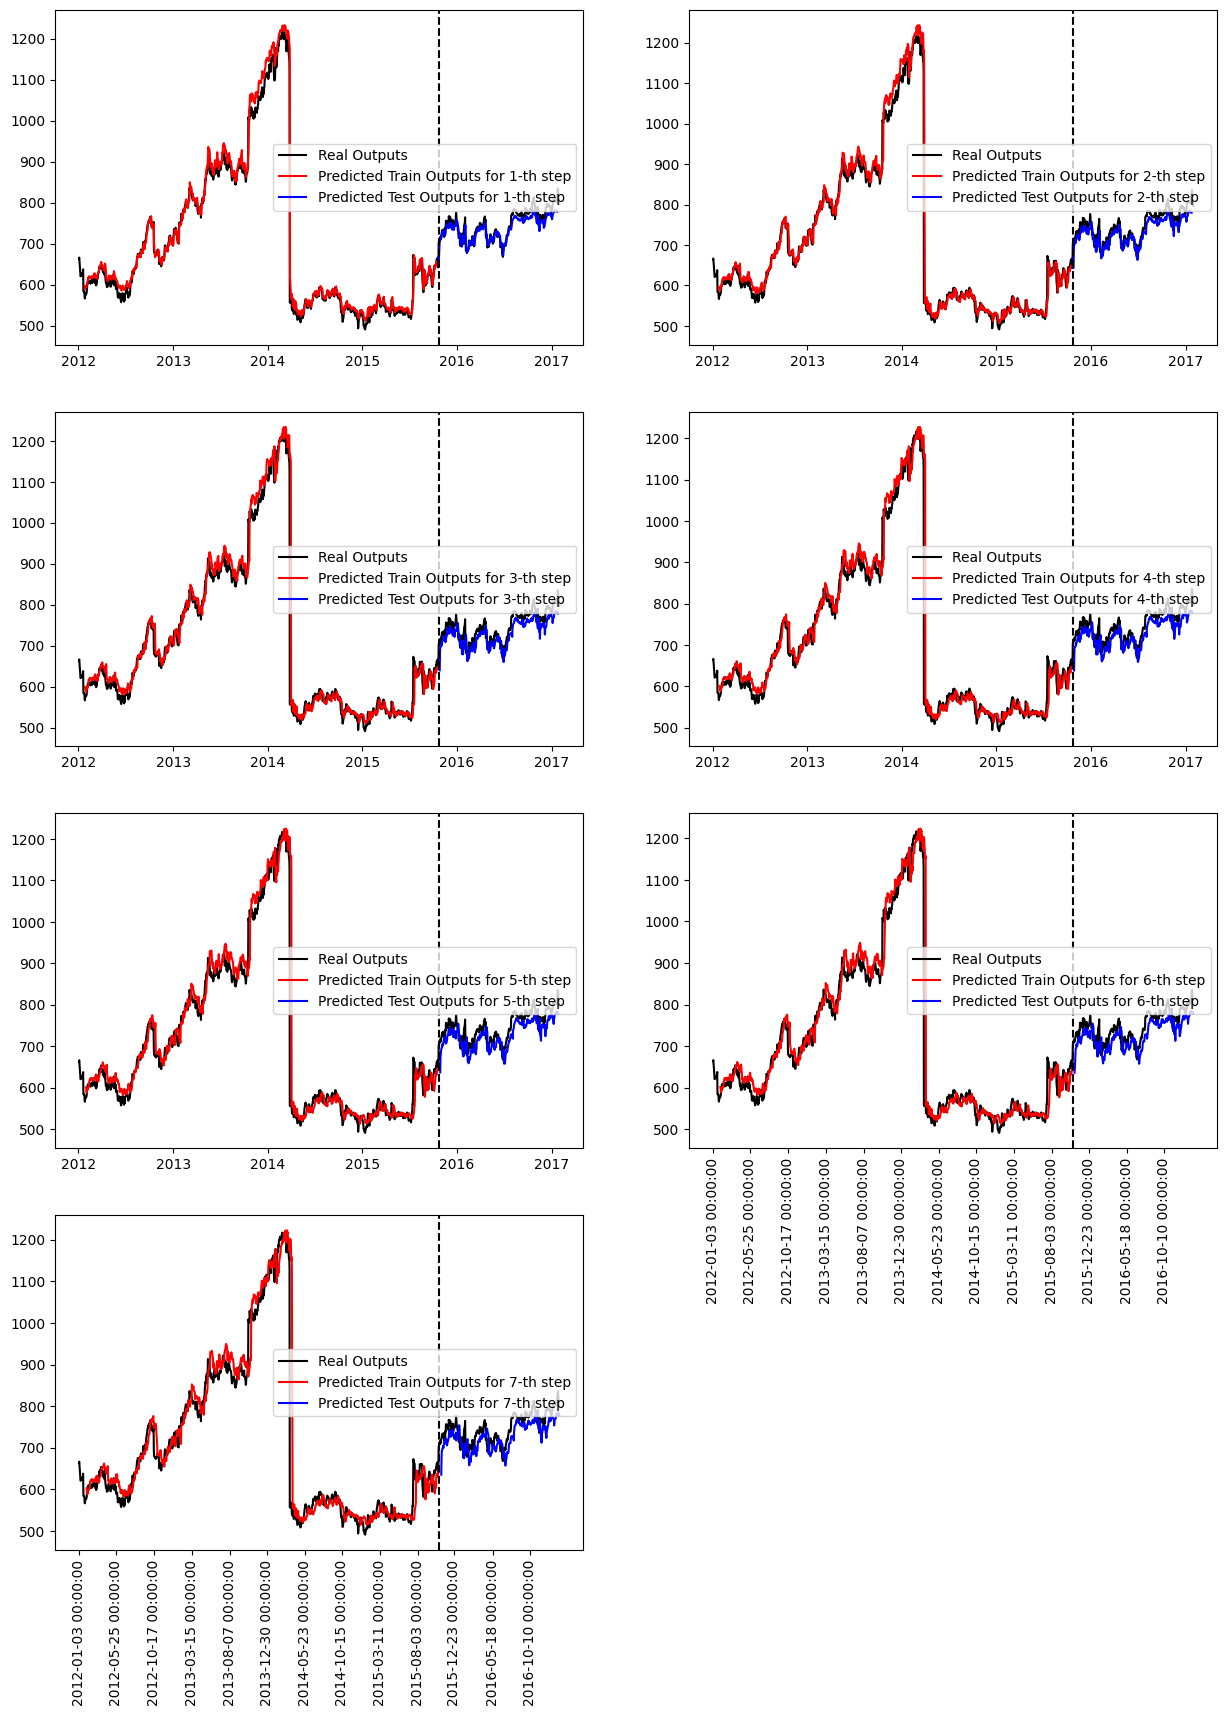

In [26]:
in_timesteps = dict_best_steps["all_features"]
train_set_norm = TimeSeriesDataset(df_train_norm, in_timesteps, OUT_QUANT,
                                   ALL_VARIABLE_NAMES, TARGET_NAME)
test_set_norm = TimeSeriesDataset(pd.concat((df_train_norm.iloc[-in_timesteps:], df_test_norm)),
                            in_timesteps, OUT_QUANT, ALL_VARIABLE_NAMES, TARGET_NAME)
test_set = TimeSeriesDataset(pd.concat((df_train.iloc[-in_timesteps:], df_test)),
                            in_timesteps, OUT_QUANT, ALL_VARIABLE_NAMES, TARGET_NAME)

nnetwork = deepcopy(NETWORK_TEMPLATE).to(DEVICE)
optimizer = GLOBAL_OPTIMIZER(nnetwork.parameters())
scheduler = GLOBAL_SCHEDULER(optimizer)    

backprop_training = BackpropTraining(nnetwork, scheduler, GLOBAL_CRITERION, optimizer,
    train_set_norm, test_set_norm, test_set, 
    checkpoint_dir=f"{LAB_THREE_DIR}/{type(nnetwork).__name__}_GS_checkpoints" +\
                                     '_' + "_".join(ALL_VARIABLE_NAMES) + "/grid_search_best_cpt",
    global_verbosity=False)

rmse_train, rmse_test, rmse_test_vec = backprop_training.test_and_plot()

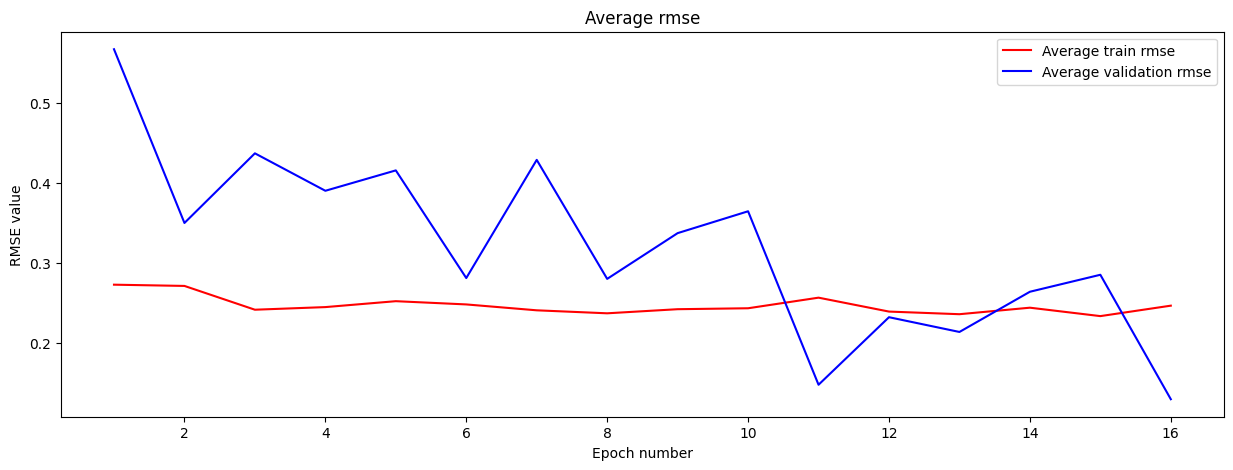

In [27]:
backprop_training.plot_metrics()

In [28]:
print(f"RMSE on the training set is: {rmse_train}")
print(f"RMSE on the testing set is: {rmse_test}")
print(f"RMSE for each of the 7 points on the testing set: {rmse_test_vec}")

RMSE on the training set is: 45.870553365047
RMSE on the testing set is: 23.988335635930042
RMSE for each of the 7 points on the testing set: [14.615059 18.933702 22.594477 24.874565 26.44719  27.842157 29.190804]
